In [155]:
import pandas as pd 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import cmdstanpy
import arviz as az
import numpy as np
from scipy.stats import beta

### 1.Data Cleaning + Representation

* userid = id of the users
* version = wherever they were put of the control at 30 or the experiment at 40
* sum_gamerounds = the total number of games played in the first 14 days
* retention_1 = did the player come back after 1 day
* rete

### Explanation of the Variables

In [160]:
cookie_data = pd.read_csv("cookie_cats.csv")
cookie_data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,FALSE
1,337,gate_30,38,True,FALSE
2,377,gate_40,165,True,FALSE
3,483,gate_40,1,False,FALSE
4,488,gate_40,179,True,TRUE
...,...,...,...,...,...
34004,3771925,gate_30,93,True,FALSE
34005,3771954,gate_30,164,True,TRUE
34006,3771962,gate_30,1,False,FALSE
34007,3772171,gate_30,42,False,FALSE


In [162]:
cookie_data['retention_7'] = cookie_data['retention_7'].map({'TRUE': True, 'FALSE': False})

In [164]:
cookie_data.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7       object
dtype: object

In [166]:
cookie_data.info

<bound method DataFrame.info of         userid  version  sum_gamerounds  retention_1 retention_7
0          116  gate_30               3        False       False
1          337  gate_30              38         True       False
2          377  gate_40             165         True       False
3          483  gate_40               1        False       False
4          488  gate_40             179         True        True
...        ...      ...             ...          ...         ...
34004  3771925  gate_30              93         True       False
34005  3771954  gate_30             164         True        True
34006  3771962  gate_30               1        False       False
34007  3772171  gate_30              42        False       False
34008  3772312  gate_30               7        False         NaN

[34009 rows x 5 columns]>

In [168]:
cookie_data.version.value_counts()

version
gate_40    17039
gate_30    16970
Name: count, dtype: int64

In [170]:
cookie_data.retention_7.value_counts()

retention_7
False    27672
True      6336
Name: count, dtype: int64

#### Check for missing values

In [173]:
total_missing = cookie_data.isnull().sum().sum()
print(total_missing)

1


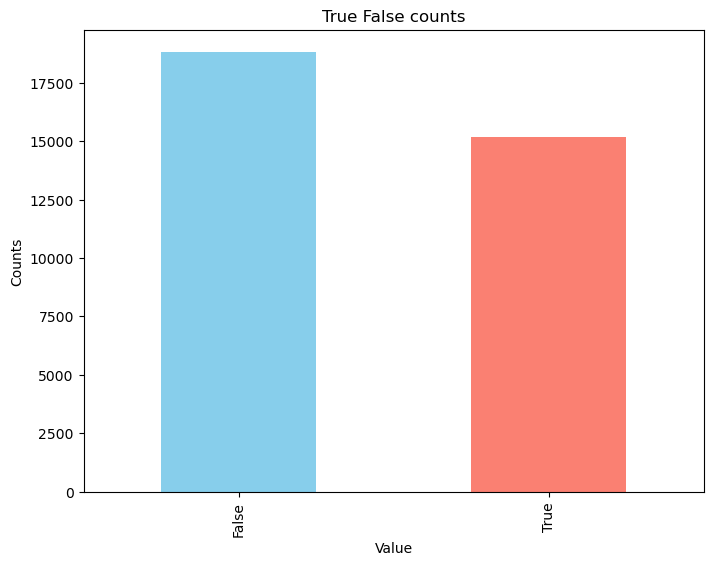

In [175]:
true_false_counts = cookie_data['retention_1'].value_counts()

plt.figure(figsize = (8,6))
true_false_counts.plot(kind='bar',color =['skyblue','salmon'])
plt.title('True False counts')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

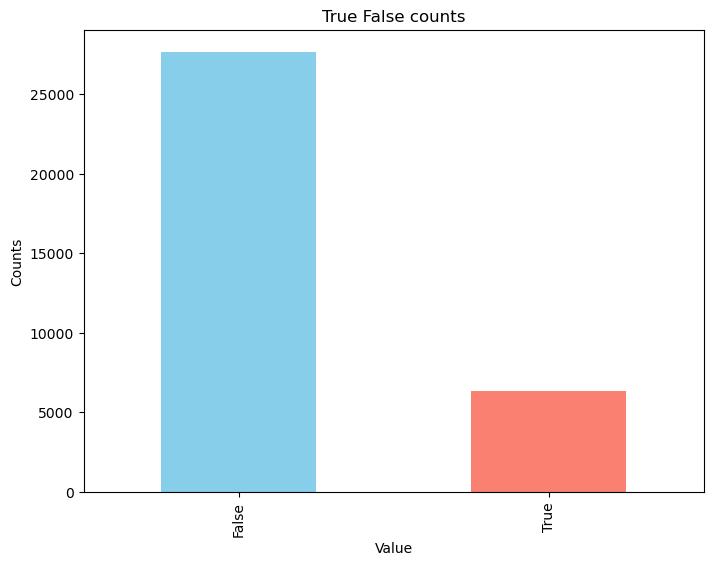

In [177]:
true_false_counts = cookie_data['retention_7'].value_counts()

plt.figure(figsize = (8,6))
true_false_counts.plot(kind='bar',color =['skyblue','salmon'])
plt.title('True False counts')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

#### Distribution of number of game rounds

Text(0.5, 1.0, 'Game rounds played during 14 days')

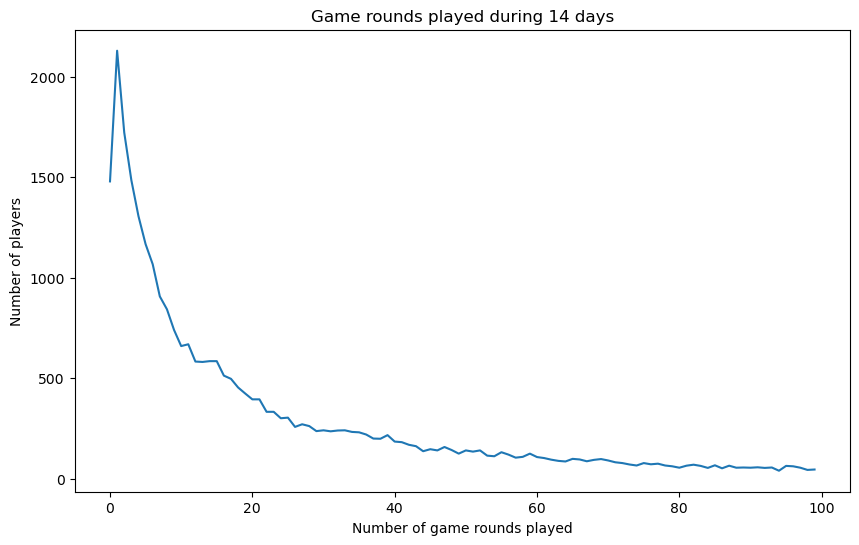

In [180]:
graph = cookie_data.groupby('sum_gamerounds').count().reset_index()
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='sum_gamerounds', y='userid', data=graph.head(n=100))
ax.set_xlabel('Number of game rounds played')
ax.set_ylabel('Number of players')
ax.set_title('Game rounds played during 14 days')

In [182]:
cookie_data['retention_1'].mean()

0.44676409185803756

In [184]:
cookie_data.groupby('version')['retention_1'].mean()

version
gate_30    0.447024
gate_40    0.446505
Name: retention_1, dtype: float64

In [186]:
cookie_data.groupby('version')['retention_7'].mean()

version
gate_30    0.189699
gate_40    0.182933
Name: retention_7, dtype: object

### 2.Statistical Test and Modelling

* Null Hypothesis: The retention rate in the two groups is the same
* Alternative: The retention rate in the group at 30 is higher than the group at 40

In [190]:
## Create a contigency table

contingency = pd.DataFrame(data= {'version' : ['gate_30', 'gate_40']})
contingency['retained_1'] = cookie_data[cookie_data['retention_1']==True].groupby(by='version').count()['retention_1'].values
contingency['non_retained_1'] = cookie_data[cookie_data['retention_1'] == False].groupby(by='version').count()['retention_1'].values
contingency['retained_7'] = cookie_data[cookie_data['retention_7']==True].groupby(by='version').count()['retention_7'].values
contingency['non_retained_7'] = cookie_data[cookie_data['retention_7'] == False].groupby(by='version').count()['retention_7'].values



In [192]:
contingency

,version,retained_1,non_retained_1,retained_7,non_retained_7
0,gate_30,7586,9384,3219,13750
1,gate_40,7608,9431,3117,13922


In [194]:
## Chi Squared Test for 1 day
res, pvalue,fred,freq = stats.chi2_contingency(contingency[['retained_1','non_retained_1']])
print(f"Chi-Squared Statistic: {res}")
print(f"p-value: {pvalue}")

Chi-Squared Statistic: 0.007287509923091523
p-value: 0.9319696963052556


In [196]:
# Chi-squared test for 7-day retention
res, pvalue,fred,freq = stats.chi2_contingency(contingency[['retained_7','non_retained_7']])
print(f"Chi-Squared Statistic: {res}")
print(f"p-value: {pvalue}")

Chi-Squared Statistic: 2.5226331691919897
p-value: 0.1122230514089047


### Bayesian Test

#### Day 1 retention rates, posterior probs

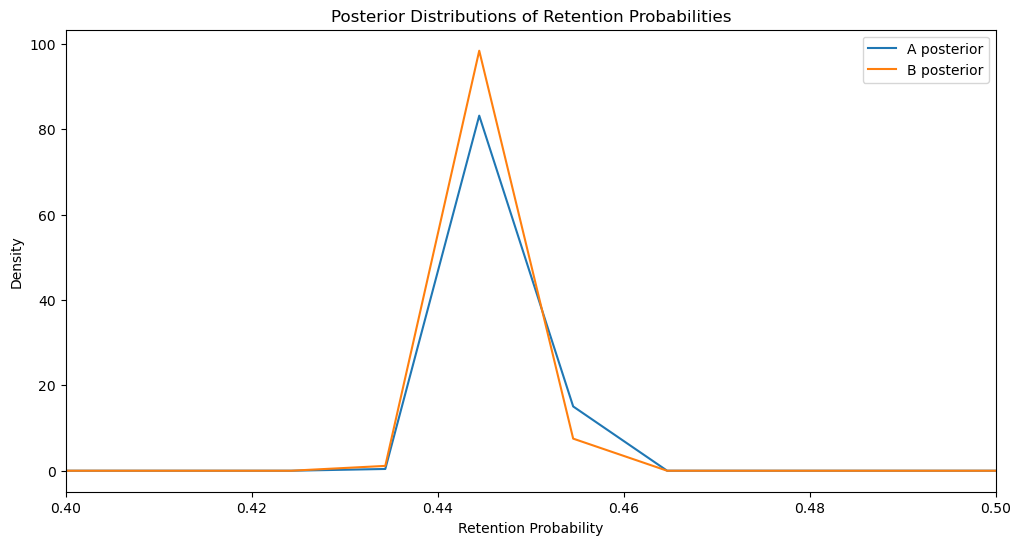

In [253]:
A_data = cookie_data[cookie_data['version'] == 'gate_30'].retention_1.values
B_data = cookie_data[cookie_data['version'] == 'gate_40'].retention_1.values

A_sucess = np.sum(A_data)
A_trials = len(A_data)
B_sucess = np.sum(B_data)
B_trials = len(B_data)

alpha_pr = 1
beta_pr = 1

A_alpha_post = alpha_pr + A_sucess
A_beta_post = beta_pr + A_trials - A_sucess
B_alpha_post = alpha_pr + A_sucess
B_beta_post = beta_pr + B_trials - B_sucess

p = np.linspace(0,1,100)

A_post = beta(A_alpha_post, A_beta_post)
B_post = beta(B_alpha_post, B_beta_post)

plt.figure(figsize=(12, 6))
plt.plot(p, A_post.pdf(p), label='A posterior')
plt.plot(p, B_post.pdf(p), label='B posterior')
plt.xlabel('Retention Probability')
plt.ylabel('Density')
plt.legend()
plt.title('Posterior Distributions of Retention Probabilities')
plt.xlim(0.4,0.50)
plt.show()

# Difference in retention probabbilities

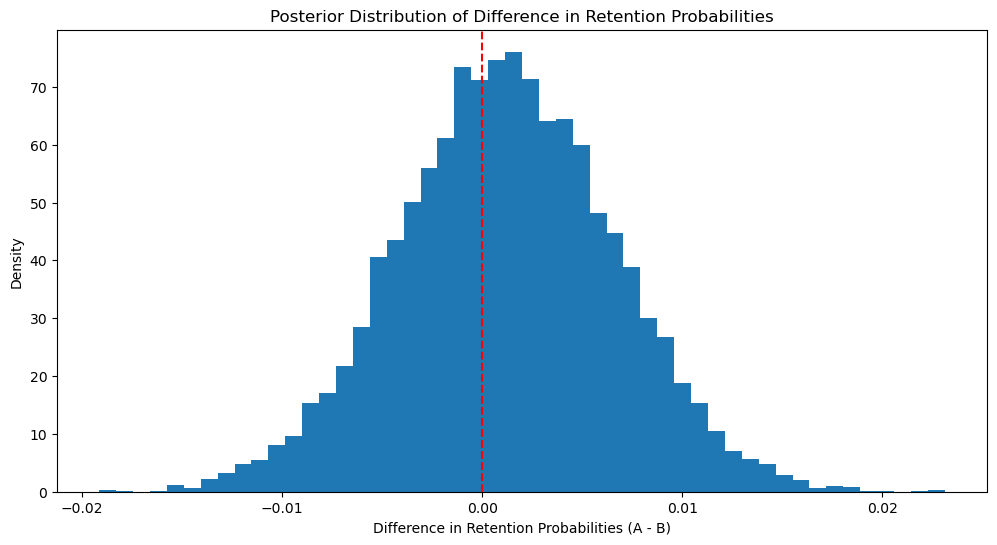

Probability that retention of A is greater than B: 0.59


In [203]:
sample_A = A_post.rvs(10000)
sample_B = B_post.rvs(10000)
diff = sample_A - sample_B

plt.figure(figsize=(12, 6))
plt.hist(diff, bins=50, density=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Difference in Retention Probabilities (A - B)')
plt.ylabel('Density')
plt.title('Posterior Distribution of Difference in Retention Probabilities')
plt.show()

# Calculate the probability that A is greater than B
prob_A_greater_B = np.mean(diff > 0)
print(f"Probability that retention of A is greater than B: {prob_A_greater_B:.2f}")

#### Day 7 retention rates, posterior probs

In [212]:
cookie_data.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

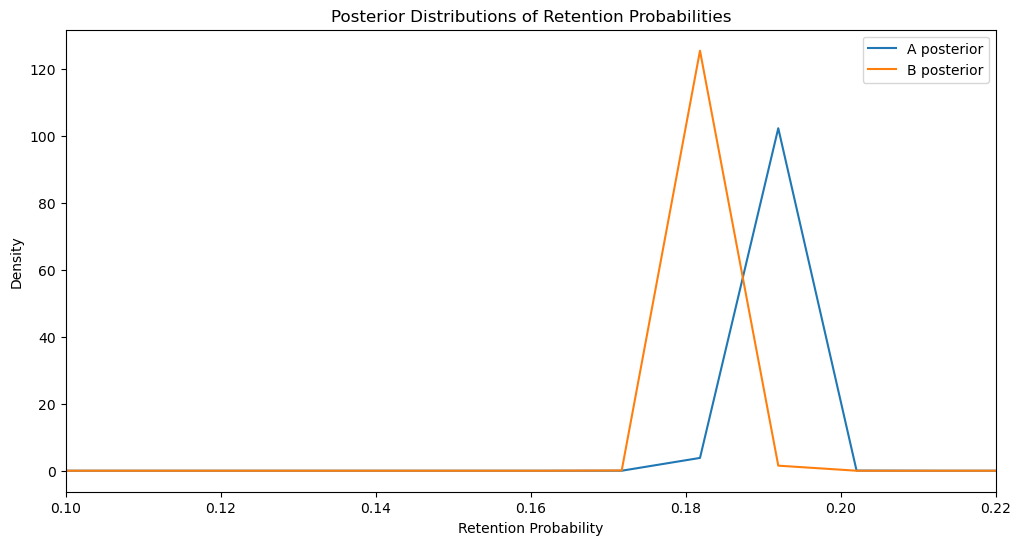

In [249]:
cookie_data['retention_7'] = cookie_data['retention_7'].astype('bool')

A_data = cookie_data[cookie_data['version']== 'gate_30'].retention_7.value_counts()
B_data = cookie_data[cookie_data['version']== 'gate_40'].retention_7.value_counts()




A_sucess = A_data.get(True,0)
A_trials = A_data.sum()
B_sucess = B_data.get(True,0)
B_trials = B_data.sum()

alpha_prior = 1
beta_prior = 1

A_alpha_post = alpha_prior + A_sucess
A_beta_post = beta_prior + A_trials - A_sucess
B_alpha_post = alpha_prior + B_sucess
B_beta_post = beta_prior + B_trials - B_sucess

p = np.linspace(0,1,100)
A_post = beta(A_alpha_post, A_beta_post)
B_post = beta(B_alpha_post, B_beta_post)




plt.figure(figsize=(12, 6))
plt.plot(p, A_post.pdf(p), label='A posterior')
plt.plot(p, B_post.pdf(p), label='B posterior')
plt.xlabel('Retention Probability')
plt.ylabel('Density')
plt.legend()
plt.title('Posterior Distributions of Retention Probabilities')
plt.xlim(0.1,0.22)
plt.show()


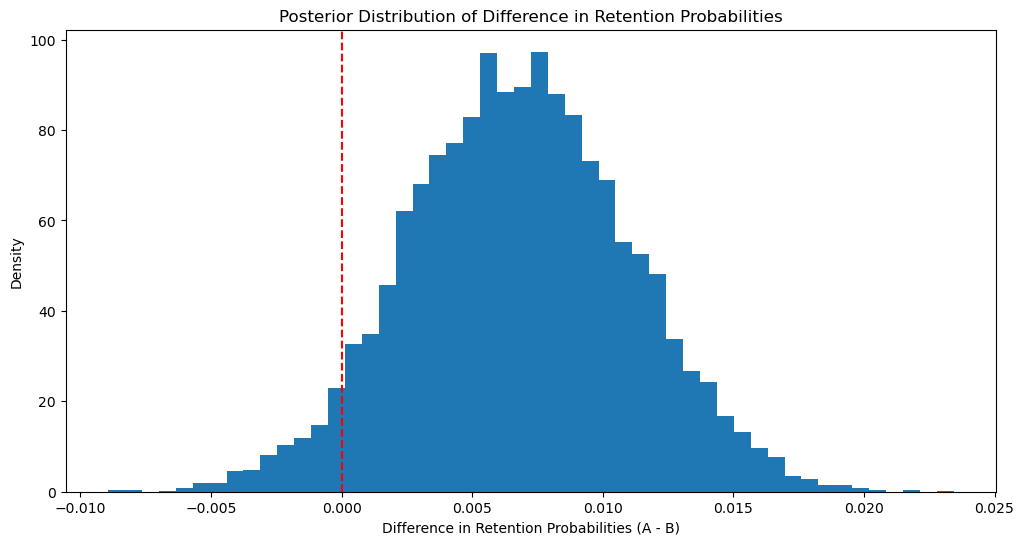

Probability that retention of A is greater than B: 0.95


In [251]:
sample_A = A_post.rvs(10000)
sample_B = B_post.rvs(10000)
diff = sample_A - sample_B

plt.figure(figsize=(12, 6))
plt.hist(diff, bins=50, density=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Difference in Retention Probabilities (A - B)')
plt.ylabel('Density')
plt.title('Posterior Distribution of Difference in Retention Probabilities')
plt.show()

# Calculate the probability that A is greater than B
prob_A_greater_B = np.mean(diff > 0)
print(f"Probability that retention of A is greater than B: {prob_A_greater_B:.2f}")